# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import f1_fn, cohen_kappa_fn
from models import PretrainedCNNClassifier
from torch import nn
from optim_utils import build_optimizer_and_scheduler
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

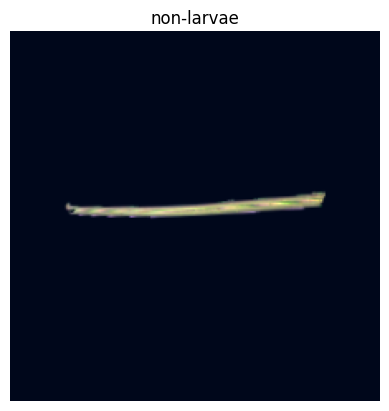

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-4,
    "lr": 5e-5,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="mobilenet_v2",
    use_dropout=True,
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [11]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=50,
)

ckpt_cnn_0 = "weights/larvae-pre-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6660 | Val Loss: 0.6587 | Train cohen_kappa_fn: 0.5194 | Val cohen_kappa_fn: 0.6234 | Train f1_fn: 0.9213 | Val f1_fn: 0.9429
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6261 | Val Loss: 0.6131 | Train cohen_kappa_fn: 0.6487 | Val cohen_kappa_fn: 0.7609 | Train f1_fn: 0.9347 | Val f1_fn: 0.9607
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5709 | Val Loss: 0.5872 | Train cohen_kappa_fn: 0.6365 | Val cohen_kappa_fn: 0.6660 | Train f1_fn: 0.9254 | Val f1_fn: 0.9364
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5298 | Val Loss: 0.5594 | Train cohen_kappa_fn: 0.6441 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9269 | Val f1_fn: 0.9403
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4859 | Val Loss: 0.5319 | Train cohen_kappa_fn: 0.6565 | Val cohen_kappa_fn: 0.6190 | Train f1_fn: 0.9292 | Val f1_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4449 | Val Loss: 0.5041 | Train cohen_kappa_fn: 0.5980 | Val cohen_kappa_fn: 0.5850 | Train f1_fn: 0.9103 | Val f1_fn: 0.9109
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4051 | Val Loss: 0.4680 | Train cohen_kappa_fn: 0.6337 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9225 | Val f1_fn: 0.9194
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3683 | Val Loss: 0.4395 | Train cohen_kappa_fn: 0.6653 | Val cohen_kappa_fn: 0.6453 | Train f1_fn: 0.9318 | Val f1_fn: 0.9276
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3482 | Val Loss: 0.4149 | Train cohen_kappa_fn: 0.6338 | Val cohen_kappa_fn: 0.5968 | Train f1_fn: 0.9204 | Val f1_fn: 0.9127
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3137 | Val Loss: 0.3953 | Train cohen_kappa_fn: 0.5843 | Val cohen_kappa_fn: 0.5968 | Train f1_fn: 0.9038 | Val f1_fn: 0.9127
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2953 | Val Loss: 0.3627 | Train cohen_kappa_fn: 0.6235 | Val cohen_kappa_fn: 0.5916 | Train f1_fn: 0.9200 | Val f1_fn: 0.9130
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2922 | Val Loss: 0.3676 | Train cohen_kappa_fn: 0.5728 | Val cohen_kappa_fn: 0.5968 | Train f1_fn: 0.9015 | Val f1_fn: 0.9127
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.2555 | Val Loss: 0.3488 | Train cohen_kappa_fn: 0.6526 | Val cohen_kappa_fn: 0.6102 | Train f1_fn: 0.9274 | Val f1_fn: 0.9170
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2631 | Val Loss: 0.3335 | Train cohen_kappa_fn: 0.6449 | Val cohen_kappa_fn: 0.6052 | Train f1_fn: 0.9238 | Val f1_fn: 0.9173
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2700 | Val Loss: 0.3433 | Train cohen_kappa_fn: 0.5986 | Val cohen_kappa_fn: 0.5585 | Train f1_fn: 0.9113 | Val f1_fn: 0.8996
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2406 | Val Loss: 0.3197 | Train cohen_kappa_fn: 0.6608 | Val cohen_kappa_fn: 0.5773 | Train f1_fn: 0.9279 | Val f1_fn: 0.9062
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2669 | Val Loss: 0.3035 | Train cohen_kappa_fn: 0.6730 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9333 | Val f1_fn: 0.9194
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2576 | Val Loss: 0.3102 | Train cohen_kappa_fn: 0.6505 | Val cohen_kappa_fn: 0.5916 | Train f1_fn: 0.9255 | Val f1_fn: 0.9130
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2274 | Val Loss: 0.3111 | Train cohen_kappa_fn: 0.7019 | Val cohen_kappa_fn: 0.6507 | Train f1_fn: 0.9427 | Val f1_fn: 0.9323
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2281 | Val Loss: 0.3129 | Train cohen_kappa_fn: 0.6887 | Val cohen_kappa_fn: 0.5984 | Train f1_fn: 0.9354 | Val f1_fn: 0.9152
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1953 | Val Loss: 0.2972 | Train cohen_kappa_fn: 0.6431 | Val cohen_kappa_fn: 0.5531 | Train f1_fn: 0.9239 | Val f1_fn: 0.9000
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2076 | Val Loss: 0.2831 | Train cohen_kappa_fn: 0.6748 | Val cohen_kappa_fn: 0.6333 | Train f1_fn: 0.9332 | Val f1_fn: 0.9258
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1895 | Val Loss: 0.2899 | Train cohen_kappa_fn: 0.7051 | Val cohen_kappa_fn: 0.6333 | Train f1_fn: 0.9425 | Val f1_fn: 0.9258
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.1975 | Val Loss: 0.2771 | Train cohen_kappa_fn: 0.6926 | Val cohen_kappa_fn: 0.6406 | Train f1_fn: 0.9393 | Val f1_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2019 | Val Loss: 0.2799 | Train cohen_kappa_fn: 0.6630 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9299 | Val f1_fn: 0.9194
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1880 | Val Loss: 0.2913 | Train cohen_kappa_fn: 0.6311 | Val cohen_kappa_fn: 0.5593 | Train f1_fn: 0.9195 | Val f1_fn: 0.9022
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1990 | Val Loss: 0.2719 | Train cohen_kappa_fn: 0.6903 | Val cohen_kappa_fn: 0.5984 | Train f1_fn: 0.9353 | Val f1_fn: 0.9152
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.1887 | Val Loss: 0.2757 | Train cohen_kappa_fn: 0.7450 | Val cohen_kappa_fn: 0.6943 | Train f1_fn: 0.9503 | Val f1_fn: 0.9423
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1933 | Val Loss: 0.2698 | Train cohen_kappa_fn: 0.7460 | Val cohen_kappa_fn: 0.6629 | Train f1_fn: 0.9522 | Val f1_fn: 0.9341
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1851 | Val Loss: 0.2603 | Train cohen_kappa_fn: 0.7008 | Val cohen_kappa_fn: 0.6052 | Train f1_fn: 0.9388 | Val f1_fn: 0.9173
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.1959 | Val Loss: 0.2874 | Train cohen_kappa_fn: 0.6820 | Val cohen_kappa_fn: 0.6102 | Train f1_fn: 0.9358 | Val f1_fn: 0.9170
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2023 | Val Loss: 0.2653 | Train cohen_kappa_fn: 0.7417 | Val cohen_kappa_fn: 0.6333 | Train f1_fn: 0.9495 | Val f1_fn: 0.9258
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1781 | Val Loss: 0.2640 | Train cohen_kappa_fn: 0.7359 | Val cohen_kappa_fn: 0.7024 | Train f1_fn: 0.9498 | Val f1_fn: 0.9443
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2039 | Val Loss: 0.2706 | Train cohen_kappa_fn: 0.7671 | Val cohen_kappa_fn: 0.6981 | Train f1_fn: 0.9561 | Val f1_fn: 0.9446
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1466 | Val Loss: 0.2947 | Train cohen_kappa_fn: 0.6654 | Val cohen_kappa_fn: 0.5531 | Train f1_fn: 0.9287 | Val f1_fn: 0.9000
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


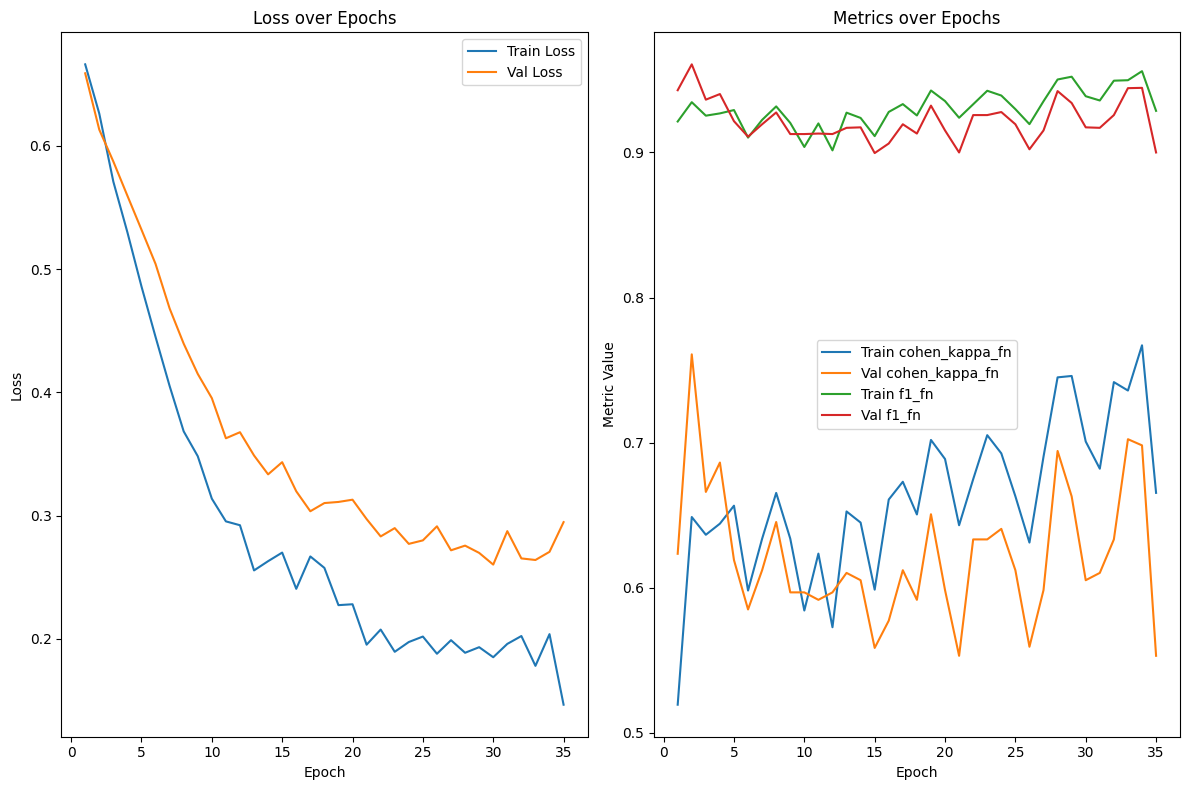

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2479 | Test cohen_kappa_fn: 0.6354 | Test f1_fn: 0.9223


#### Visualization

In [15]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

In [16]:
# Display layer representations
# visualizer_0.display_layer_representations(test_loader)

In [17]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
# larvae_done = False
# non_larvae_done = False
# for sample_img, target in test_loader.dataset:
#     if not larvae_done and target == 0:  # Larvae
#         larvae_done = True
#         visualizer_0.display_heatmap(sample_img, target)
#     elif not non_larvae_done and target == 1:  # Non-larvae
#         non_larvae_done = True
#         visualizer_0.display_heatmap(sample_img, target)
#     if larvae_done and non_larvae_done:
#         break

### 3.3. CNN1

In [18]:
cnn_1 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="squeezenet1_0",
    use_dropout=True,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [19]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=50,
)
ckpt_cnn_1 = "weights/larvae-pre-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [20]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.5930 | Val Loss: 0.4662 | Train cohen_kappa_fn: 0.4932 | Val cohen_kappa_fn: 0.5395 | Train f1_fn: 0.8695 | Val f1_fn: 0.8875
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.4465 | Val Loss: 0.3698 | Train cohen_kappa_fn: 0.6555 | Val cohen_kappa_fn: 0.7224 | Train f1_fn: 0.9283 | Val f1_fn: 0.9457
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.3503 | Val Loss: 0.3098 | Train cohen_kappa_fn: 0.6867 | Val cohen_kappa_fn: 0.7470 | Train f1_fn: 0.9366 | Val f1_fn: 0.9518
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.2999 | Val Loss: 0.2688 | Train cohen_kappa_fn: 0.7430 | Val cohen_kappa_fn: 0.7484 | Train f1_fn: 0.9524 | Val f1_fn: 0.9542
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.2596 | Val Loss: 0.2462 | Train cohen_kappa_fn: 0.7638 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9572 | Val f1_fn: 0.9582
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2284 | Val Loss: 0.2314 | Train cohen_kappa_fn: 0.7781 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9604 | Val f1_fn: 0.9582
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2117 | Val Loss: 0.2198 | Train cohen_kappa_fn: 0.7965 | Val cohen_kappa_fn: 0.8094 | Train f1_fn: 0.9653 | Val f1_fn: 0.9681
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2071 | Val Loss: 0.2125 | Train cohen_kappa_fn: 0.8028 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9659 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1882 | Val Loss: 0.1965 | Train cohen_kappa_fn: 0.8203 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9690 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1762 | Val Loss: 0.1954 | Train cohen_kappa_fn: 0.8066 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9667 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1626 | Val Loss: 0.1870 | Train cohen_kappa_fn: 0.8214 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9689 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1696 | Val Loss: 0.1843 | Train cohen_kappa_fn: 0.8077 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9667 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1721 | Val Loss: 0.1904 | Train cohen_kappa_fn: 0.8317 | Val cohen_kappa_fn: 0.8265 | Train f1_fn: 0.9722 | Val f1_fn: 0.9721
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.1513 | Val Loss: 0.1793 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9682 | Val f1_fn: 0.9700
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1467 | Val Loss: 0.1822 | Train cohen_kappa_fn: 0.8051 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9658 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1522 | Val Loss: 0.1736 | Train cohen_kappa_fn: 0.8089 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9666 | Val f1_fn: 0.9720
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1411 | Val Loss: 0.1689 | Train cohen_kappa_fn: 0.8037 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9649 | Val f1_fn: 0.9700
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1414 | Val Loss: 0.1845 | Train cohen_kappa_fn: 0.7977 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9643 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1390 | Val Loss: 0.1689 | Train cohen_kappa_fn: 0.8181 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9691 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1336 | Val Loss: 0.1692 | Train cohen_kappa_fn: 0.8176 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9681 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1273 | Val Loss: 0.1689 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9682 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1250 | Val Loss: 0.1662 | Train cohen_kappa_fn: 0.8214 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9689 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.1300 | Val Loss: 0.1589 | Train cohen_kappa_fn: 0.8138 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9674 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1161 | Val Loss: 0.1573 | Train cohen_kappa_fn: 0.8466 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9735 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1206 | Val Loss: 0.1582 | Train cohen_kappa_fn: 0.8252 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9697 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1260 | Val Loss: 0.1605 | Train cohen_kappa_fn: 0.8358 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9721 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1190 | Val Loss: 0.1574 | Train cohen_kappa_fn: 0.8447 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9736 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1108 | Val Loss: 0.1516 | Train cohen_kappa_fn: 0.8408 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9728 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1208 | Val Loss: 0.1446 | Train cohen_kappa_fn: 0.8311 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9704 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1262 | Val Loss: 0.1513 | Train cohen_kappa_fn: 0.8301 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9704 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1163 | Val Loss: 0.1489 | Train cohen_kappa_fn: 0.8584 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9758 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1039 | Val Loss: 0.1512 | Train cohen_kappa_fn: 0.8780 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9797 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1086 | Val Loss: 0.1477 | Train cohen_kappa_fn: 0.8505 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9743 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1091 | Val Loss: 0.1466 | Train cohen_kappa_fn: 0.8301 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9704 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


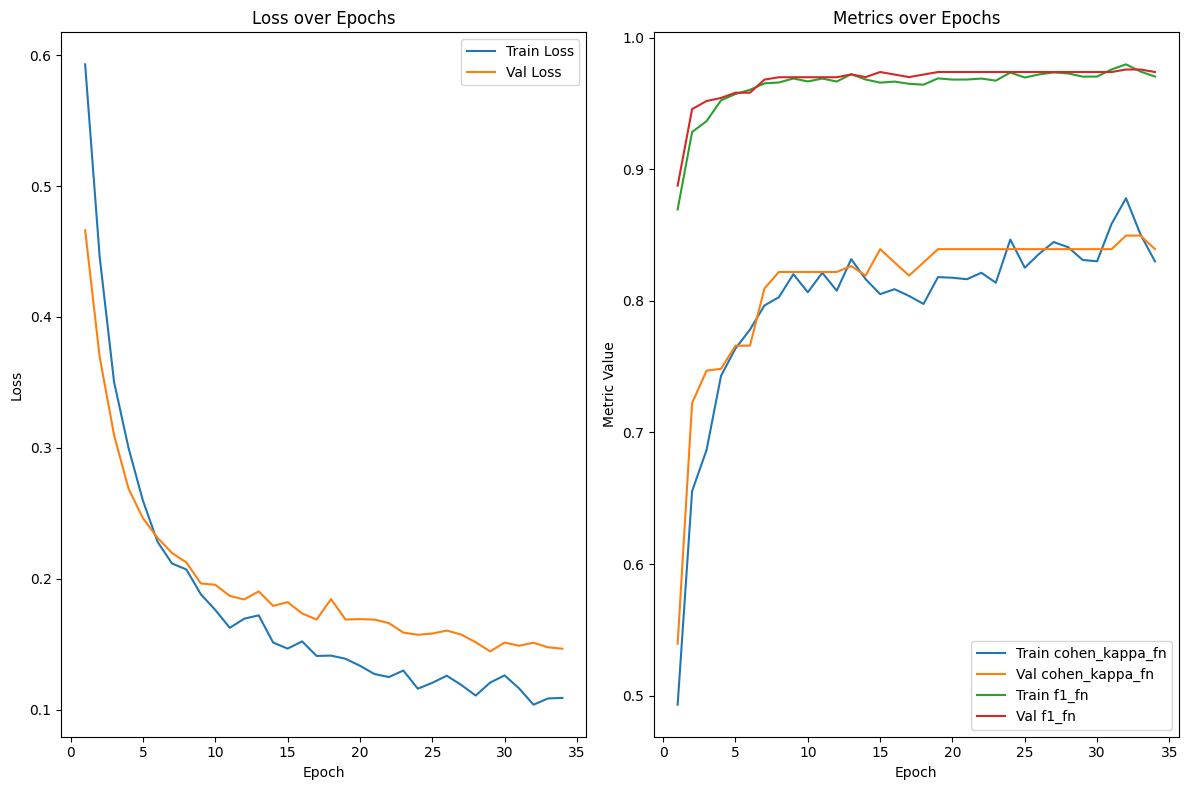

In [21]:
trainer_cnn_1.plot_epochs()

In [22]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!


Test Loss: 0.1158 | Test cohen_kappa_fn: 0.8502 | Test f1_fn: 0.9750


#### Visualization

In [23]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

In [24]:
# Display layer representations
# visualizer_1.display_layer_representations(test_loader)

In [25]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
# larvae_done = False
# non_larvae_done = False
# for sample_img, target in test_loader.dataset:
#     if not larvae_done and target == 0:  # Larvae
#         larvae_done = True
#         visualizer_1.display_heatmap(sample_img, target)
#     elif not non_larvae_done and target == 1:  # Non-larvae
#         non_larvae_done = True
#         visualizer_1.display_heatmap(sample_img, target)
#     if larvae_done and non_larvae_done:
#         break

### 3.4. CNN2

In [26]:
cnn_2 = PretrainedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    backbone="resnet18",
    use_dropout=True,
    device=device,
)
summary(cnn_2, input_shape)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/giovanne/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 11.4MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [27]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=50,
)
ckpt_cnn_2 = "weights/larvae-pre-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [28]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=50)

📘 Epoch 1 | Train Loss: 0.6638 | Val Loss: 0.5938 | Train cohen_kappa_fn: 0.3361 | Val cohen_kappa_fn: 0.5735 | Train f1_fn: 0.9254 | Val f1_fn: 0.9443
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.5767 | Val Loss: 0.5319 | Train cohen_kappa_fn: 0.5868 | Val cohen_kappa_fn: 0.6479 | Train f1_fn: 0.9172 | Val f1_fn: 0.9300
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5248 | Val Loss: 0.4858 | Train cohen_kappa_fn: 0.7422 | Val cohen_kappa_fn: 0.7016 | Train f1_fn: 0.9599 | Val f1_fn: 0.9515
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.4655 | Val Loss: 0.4322 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.6943 | Train f1_fn: 0.9452 | Val f1_fn: 0.9423
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4232 | Val Loss: 0.3989 | Train cohen_kappa_fn: 0.6964 | Val cohen_kappa_fn: 0.7193 | Train f1_fn: 0.9450 | Val f1_fn: 0.9508
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.3883 | Val Loss: 0.3662 | Train cohen_kappa_fn: 0.6968 | Val cohen_kappa_fn: 0.7064 | Train f1_fn: 0.9430 | Val f1_fn: 0.9466
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.3518 | Val Loss: 0.3431 | Train cohen_kappa_fn: 0.7298 | Val cohen_kappa_fn: 0.7193 | Train f1_fn: 0.9501 | Val f1_fn: 0.9508
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3377 | Val Loss: 0.3143 | Train cohen_kappa_fn: 0.7165 | Val cohen_kappa_fn: 0.7149 | Train f1_fn: 0.9469 | Val f1_fn: 0.9486
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3018 | Val Loss: 0.3109 | Train cohen_kappa_fn: 0.7165 | Val cohen_kappa_fn: 0.6943 | Train f1_fn: 0.9469 | Val f1_fn: 0.9423
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3030 | Val Loss: 0.2883 | Train cohen_kappa_fn: 0.7214 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9476 | Val f1_fn: 0.9488
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2674 | Val Loss: 0.2829 | Train cohen_kappa_fn: 0.6983 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9439 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2849 | Val Loss: 0.2738 | Train cohen_kappa_fn: 0.7269 | Val cohen_kappa_fn: 0.7106 | Train f1_fn: 0.9512 | Val f1_fn: 0.9488
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2506 | Val Loss: 0.2608 | Train cohen_kappa_fn: 0.6889 | Val cohen_kappa_fn: 0.7146 | Train f1_fn: 0.9404 | Val f1_fn: 0.9462
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2389 | Val Loss: 0.2556 | Train cohen_kappa_fn: 0.7435 | Val cohen_kappa_fn: 0.7189 | Train f1_fn: 0.9533 | Val f1_fn: 0.9484
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2400 | Val Loss: 0.2549 | Train cohen_kappa_fn: 0.7632 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9582 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2475 | Val Loss: 0.2430 | Train cohen_kappa_fn: 0.7682 | Val cohen_kappa_fn: 0.7234 | Train f1_fn: 0.9589 | Val f1_fn: 0.9506
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2359 | Val Loss: 0.2504 | Train cohen_kappa_fn: 0.7519 | Val cohen_kappa_fn: 0.7274 | Train f1_fn: 0.9549 | Val f1_fn: 0.9504
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.1982 | Val Loss: 0.2417 | Train cohen_kappa_fn: 0.7625 | Val cohen_kappa_fn: 0.7149 | Train f1_fn: 0.9573 | Val f1_fn: 0.9486
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2191 | Val Loss: 0.2355 | Train cohen_kappa_fn: 0.7841 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9620 | Val f1_fn: 0.9526
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1884 | Val Loss: 0.2308 | Train cohen_kappa_fn: 0.7430 | Val cohen_kappa_fn: 0.7313 | Train f1_fn: 0.9524 | Val f1_fn: 0.9502
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2093 | Val Loss: 0.2300 | Train cohen_kappa_fn: 0.7445 | Val cohen_kappa_fn: 0.7313 | Train f1_fn: 0.9523 | Val f1_fn: 0.9502
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2003 | Val Loss: 0.2368 | Train cohen_kappa_fn: 0.8042 | Val cohen_kappa_fn: 0.7370 | Train f1_fn: 0.9668 | Val f1_fn: 0.9547
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2234 | Val Loss: 0.2140 | Train cohen_kappa_fn: 0.7359 | Val cohen_kappa_fn: 0.7484 | Train f1_fn: 0.9498 | Val f1_fn: 0.9542
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.2215 | Val Loss: 0.2252 | Train cohen_kappa_fn: 0.7666 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9571 | Val f1_fn: 0.9522
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1970 | Val Loss: 0.2312 | Train cohen_kappa_fn: 0.7965 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9643 | Val f1_fn: 0.9526
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2057 | Val Loss: 0.2172 | Train cohen_kappa_fn: 0.7195 | Val cohen_kappa_fn: 0.7268 | Train f1_fn: 0.9457 | Val f1_fn: 0.9480
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1875 | Val Loss: 0.2232 | Train cohen_kappa_fn: 0.8224 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9689 | Val f1_fn: 0.9526
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1818 | Val Loss: 0.2228 | Train cohen_kappa_fn: 0.7513 | Val cohen_kappa_fn: 0.7321 | Train f1_fn: 0.9539 | Val f1_fn: 0.9526
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


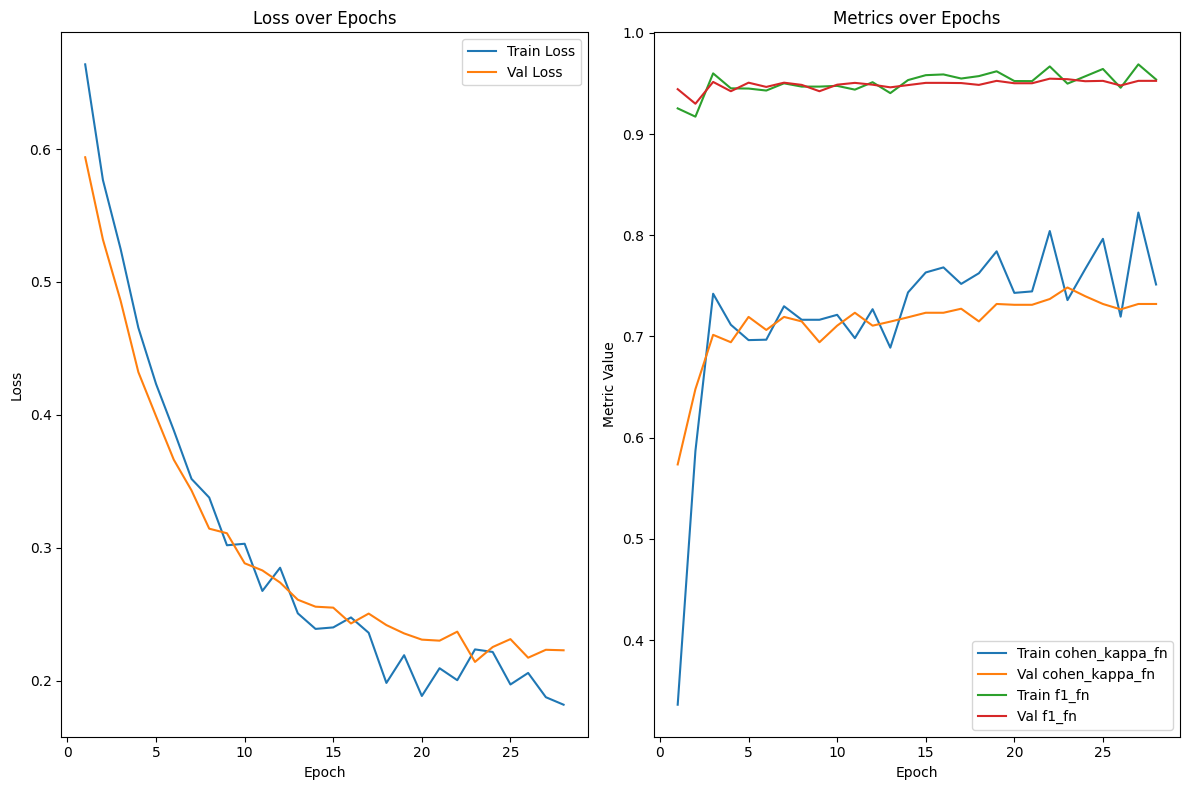

In [29]:
trainer_cnn_2.plot_epochs()

In [30]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1700 | Test cohen_kappa_fn: 0.7310 | Test f1_fn: 0.9486


#### Visualization

In [31]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

In [32]:
# Display layer representations
# visualizer_2.display_layer_representations(test_loader)

In [33]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
# larvae_done = False
# non_larvae_done = False
# for sample_img, target in test_loader.dataset:
#     if not larvae_done and target == 0:  # Larvae
#         larvae_done = True
#         visualizer_2.display_heatmap(sample_img, target)
#     elif not non_larvae_done and target == 1:  # Non-larvae
#         non_larvae_done = True
#         visualizer_2.display_heatmap(sample_img, target)
#     if larvae_done and non_larvae_done:
#         break